# Potřebné knihovny

1) pandas - pro manipulaci s daty
2) numpy - pro práci s pravděpodobnostní distribucí
3) seaborn - pro vizualizaci
4) modul geodesic z knihovny geopy pro výpočet vzdáleností mezi místy

In [29]:
import pandas as pd
import numpy as np
import seaborn as sb
from geopy.distance import geodesic

In [30]:
## nahrání dat
police_stations_data = pd.read_csv('Police_Station.csv', sep = ',', header = 0)
crime_data = pd.read_csv('crimes.csv', sep = ',', header = 0)

## pracujeme se strukturou DataFrame
police_stations = pd.DataFrame(police_stations_data)
crime = pd.DataFrame(crime_data)
 

/tmp/ipykernel_472/591106611.py:3: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('crimes.csv', sep = ',', header = 0)


# Průzkum datasetu Police station

Máme k dispozici 10 záznamů a pro každý 10 atributů.

Větší část z nich nás nebude zajímat, neboť jsou to spíše číselníkové hodnoty, u kterých nemáme jasnou interpretaci nebo jsou u všech policejních stanic stejné, tudíž nemají žádnou hodnotu informace.

Dataframe si tedy omezíme na sloupce:
1) subtype - typ stanice
2) nghbrhd - sousedství
3) plcdst - čtvrť
4) latitude - zeměpisná šířka
5) longitude - zeměpisná délka

Poslední 2 atributy byly pro zajímavější analýzu doplněny s pomocí https://mapasamerica.dices.net/, kde byly pro jednotlivé policejní stanice zjištěny jejich zěmepisné šířky a délky ve formátu, který je kompatibilní s druhým datasetem.

In [31]:
police_stations.info()
police_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           10 non-null     float64
 1   Y           10 non-null     float64
 2   OBJECTID    10 non-null     int64  
 3   gis_id      10 non-null     object 
 4   srcid_t     10 non-null     int64  
 5   srcid_i     10 non-null     int64  
 6   edit_date   10 non-null     object 
 7   ftype       10 non-null     int64  
 8   subtype     10 non-null     object 
 9   loc_type    10 non-null     object 
 10  loc_meth    10 non-null     object 
 11  street_tag  10 non-null     object 
 12  prcl_pin    10 non-null     object 
 13  address     10 non-null     object 
 14  city        10 non-null     object 
 15  state       10 non-null     object 
 16  zipcode     10 non-null     int64  
 17  x_coord     10 non-null     float64
 18  y_coord     10 non-null     float64
 19  name        10 non-null     obje

,X,Y,OBJECTID,gis_id,srcid_t,srcid_i,edit_date,ftype,subtype,loc_type,...,commander,phone,cntct_nme,cntct_phn,cntct_dpt,globalid,url,GlobalID_2,Latitude,Longitude
0,-8.527929e+06,4.763330e+06,1,24_1,6,0,2011/03/29 00:00:00+00,24,Headquarters,CP,...,"Commissioner Frederick H. Bealefeld, III",410-396-2525,,,,{8E12DA2D-B060-4FFF-B73D-A6D95EC36ED7},,63f88c84-1262-4ec7-9d24-4d0a6d3d9ae2,39.3230,-76.6223
1,-8.528023e+06,4.763298e+06,2,24_2,9,0,2011/03/29 00:00:00+00,24,Police Station,CP,...,Major Dennis Smtih,410-396-2411,,,,{BB91946E-3DB9-44DD-B27F-AFA4038E6051},,40c4f080-eaa9-4112-b59b-2d5146b239f6,39.2900,-76.6085
2,-8.532860e+06,4.770898e+06,3,24_3,10,0,2011/03/29 00:00:00+00,24,Police Station,CP,...,Major Ross Buzzuro,410-396-2455,,,,{57BDA944-4DCD-4FC8-B580-8DCD5FC8C31C},,cd3c1d76-52bc-4893-b8bc-0380188a6568,39.3431,-76.6524
3,-8.525151e+06,4.770651e+06,4,24_4,11,0,2011/03/29 00:00:00+00,24,Police Station,CP,...,"Major Delmar Dickson, Jr.",410-396-2444,,,,{79A16D87-5ED1-4523-A623-FB5C7BF0C824},,8ca6c8f6-7f5c-4f72-924c-daf8aec51cbd,39.3408,-76.5828
4,-8.536553e+06,4.771189e+06,5,24_5,12,0,2011/03/29 00:00:00+00,24,Police Station,CP,...,Major Johnny Delgado,410-396-2466,,,,{57A7C213-295E-4CE7-9B5F-AB42C6DC0773},,fdd3a23a-01b8-4472-a2af-a66c3e9a643b,39.3446,-76.6854


In [32]:
## extrakce požadovaných atributů
police_stations = police_stations[['subtype','nghbrhd','plcdst','Latitude','Longitude']]

police_stations.head()

,subtype,nghbrhd,plcdst,Latitude,Longitude
0,Headquarters,Downtown,CENTRAL,39.3230,-76.6223
1,Police Station,Downtown,CENTRAL,39.2900,-76.6085
2,Police Station,Woodberry,NORTHERN,39.3431,-76.6524
3,Police Station,Morgan State University,NORTHEASTERN,39.3408,-76.5828
4,Police Station,Woodmere,NORTHWESTERN,39.3446,-76.6854


# Průzkum datasetu Crimes

Máme k dispozici celkem 609 830 záznamů a pro každý 23 atributů.

Z výpisu atributl je patrné, že v některých bude problém s chybějícími hodnotami. S tímto datasetem budeme dále provádět větší množství transformací, abychom dostali přívětivou datovou sadu pro analýzu.

Atributy, které si předbězně vybíráme pro práci jsou:
1) CrimeDateTime - datum spáchání zločinu
2) Description - typ zločinu
3) Weapon - použitá zbraň
4) Gender - pohlaví oběti
5) Age - věk oběti
6) Race - rasa oběti
7) Ethnicity - etnikum oběti
8) Old_District - čtvrť, ve které byl spáchán daný zločin
9) Neighborhood - sousedství, ve kterém byl spáchán daný zločin
10) PremiseType - typ místa, na kterém byl spáchán zločin
11) Total_Incidents - kolik zločinů se na daném místě stalo v daný okamžik
12) Latitude - zeměpisná šířka
13) Longitude - zeměpisná délka

In [33]:
crime.info()
crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613233 entries, 0 to 613232
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   RowID            613233 non-null  int64  
 1   CCNumber         613233 non-null  object 
 2   CrimeDateTime    613233 non-null  object 
 3   CrimeCode        613233 non-null  object 
 4   Description      613233 non-null  object 
 5   Inside_Outside   0 non-null       float64
 6   Weapon           149575 non-null  object 
 7   Post             605247 non-null  float64
 8   Gender           515282 non-null  object 
 9   Age              495039 non-null  float64
 10  Race             588307 non-null  object 
 11  Ethnicity        84033 non-null   object 
 12  Location         609457 non-null  object 
 13  Old_District     566806 non-null  object 
 14  New_District     38452 non-null   object 
 15  Neighborhood     604458 non-null  object 
 16  Latitude         612167 non-null  floa

,RowID,CCNumber,CrimeDateTime,CrimeCode,Description,Inside_Outside,Weapon,Post,Gender,Age,...,Old_District,New_District,Neighborhood,Latitude,Longitude,GeoLocation,PremiseType,Total_Incidents,x,y
0,1,13I02088,9/5/2013 6:30:00 AM,6D,LARCENY FROM AUTO,NaN,NaN,534.0,F,48.0,...,NORTHERN,NaN,MEDFIELD,39.339060,-76.641489,"(39.33906,-76.641489)",STREET,1,-76.641489,39.339060
1,2,13I02825,9/5/2013 9:00:00 PM,4D,AGG. ASSAULT,NaN,HANDS,232.0,F,11.0,...,SOUTHEAST,NaN,BAYVIEW,39.289023,-76.538116,"(39.289023,-76.538116)",ROW/TOWNHOUSE-OCC,1,-76.538116,39.289023
2,3,13I02282,9/5/2013 3:45:00 PM,4E,COMMON ASSAULT,NaN,NaN,324.0,M,22.0,...,EASTERN,NaN,PENN-FALLSWAY,39.300483,-76.606101,"(39.300482803931502,-76.606101271553172)",STREET,1,-76.606101,39.300483
3,4,13I02027,9/5/2013 1:10:00 AM,3AF,ROBBERY,NaN,FIREARM,534.0,F,23.0,...,NORTHERN,NaN,ROLAND PARK,39.352701,-76.638843,"(39.352701319240794,-76.638842742883625)",STREET,1,-76.638843,39.352701
4,5,13I02527,9/5/2013 8:00:00 PM,5D,BURGLARY,NaN,NaN,931.0,M,27.0,...,SOUTHERN,NaN,HOLLINS MARKET,39.286143,-76.636664,"(39.286143,-76.636664)",SHED/GARAGE,1,-76.636664,39.286143


In [34]:
## extrakce požadovaných atributů
crime = crime[['CrimeDateTime', 'Description','Weapon', 'Gender', 'Age', 'Race', 'Ethnicity', 'Old_District','Neighborhood','PremiseType','Total_Incidents','Latitude','Longitude']]
crime.head()

,CrimeDateTime,Description,Weapon,Gender,Age,Race,Ethnicity,Old_District,Neighborhood,PremiseType,Total_Incidents,Latitude,Longitude
0,9/5/2013 6:30:00 AM,LARCENY FROM AUTO,NaN,F,48.0,WHITE,NaN,NORTHERN,MEDFIELD,STREET,1,39.339060,-76.641489
1,9/5/2013 9:00:00 PM,AGG. ASSAULT,HANDS,F,11.0,BLACK_OR_AFRICAN_AMERICAN,NaN,SOUTHEAST,BAYVIEW,ROW/TOWNHOUSE-OCC,1,39.289023,-76.538116
2,9/5/2013 3:45:00 PM,COMMON ASSAULT,NaN,M,22.0,BLACK_OR_AFRICAN_AMERICAN,NaN,EASTERN,PENN-FALLSWAY,STREET,1,39.300483,-76.606101
3,9/5/2013 1:10:00 AM,ROBBERY,FIREARM,F,23.0,WHITE,NaN,NORTHERN,ROLAND PARK,STREET,1,39.352701,-76.638843
4,9/5/2013 8:00:00 PM,BURGLARY,NaN,M,27.0,UNKNOWN,NaN,SOUTHERN,HOLLINS MARKET,SHED/GARAGE,1,39.286143,-76.636664


## Odvození nových atributů

### Měsíc zločinu

Poměrně zajímavé by bylo analyzovat vztahy ne ke konkrétnímu datu (příliš mnoho hodnot, že by se to dalo už i považovat za spojitý atribit), ale k měsíci. Můžeme z toho vyvozovat některé otázky týkající se vztahu měsíce a zločinů.

Dataframe datumový atribut jako datum nevidí, proto je zapotřebí ho převést na datum v daném formátu.

Jakmile budeme mít k dispozici atribut v datumovém formátu, nic nám nebrání z něj vyextrahovat daný měsíc za pomoci některých datumových funkcí.


V kódu níže je vidět i způsob práce s prázdnými hodnotami.


### Denní doba zločinu

Zajímavé otázky bychom mohli získat i analýzou denní doby zločinu nebo dokonce konkrétní hodiny.

Vyextrahujeme si tedy hodinu, ve které se zločin stal a dále vytvoříme ještě jeden atribut, který bude reprezentovat denní dobu.

Denní doba bude tedy diskretizace hodinového atributu na kategorie:

1) Early morning - 0 - 5 hodin
2) Morning - 6 - 11 hodin
3) Afternoon - 12 - 16 hodin
4) Evening - 17 - 20 hodin
5) Night - 21 - 24 hodin

In [35]:
"""
formát kopíruji přesně z datasetu

vzhledem k přesnosti dané časové značky jsme omezeni uložištěm, které Pandas alokuje pro časovou značku a tedy jsme omezeni i velikostí intervalu možných let

v datech se vyskytují nějaké zřejmé chyby, kdy rok spáchání zločinu je mimo interval, který je možno uložit - proto volba errors = coerce, 
díky které se z nepřeveditelné hodnoty stane null
"""

crime['CrimeDateTime'] = pd.to_datetime(crime['CrimeDateTime'], format ="%m/%d/%Y %I:%M:%S %p", errors='coerce');


In [36]:
## extrahujeme měsíc do nového sloupce Month. Použijeme anglickou lokalizaci, abychom se nemuseli potýkat s kódováním
crime['Month'] = crime['CrimeDateTime'].dt.month_name();

In [37]:
print(crime['Month'].isna().sum()); ## pouze 4 hodnoty chybí -> nahrazujeme nejčastějí hodnotou

month_mode = crime['Month'].mode()[0];  ## Srpen (August)

crime['Month'].fillna(month_mode, inplace = True);

print(crime['Month'].isna().sum()); ## po doplnění máme 0 prádných hodnot

4
0


/tmp/ipykernel_472/2354767242.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime['Month'].fillna(month_mode, inplace = True);


In [38]:
## extrahujeme hodinu do nového atributu Hour
crime['Hour'] = crime['CrimeDateTime'].dt.hour;


In [39]:
## podobně jako u měsíce naplňujeme chybějící hodnoty modem
hour_mode = crime['Hour'].mode()[0];  ## Srpen (August)

crime['Hour'].fillna(hour_mode, inplace = True);

/tmp/ipykernel_472/2362276267.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime['Hour'].fillna(hour_mode, inplace = True);


In [40]:
## provedeme diskretizaci hodinového atributu do nového atributu Daytime
crime['Daytime'] = crime['Hour'].apply(lambda x: 'Early Morning' if (x > 0 and x < 6) else ('Morning' if (x > 5 and x<12) else ('Afternoon' if (x >11 and x < 17) else ('Evening' if (x > 16 and x < 21) else 'Night'))));

## Atribut Weapon

U zbraňového atributu nemáme vyplněnou nějakou část hodnot (je to vidět už u náhledu výše). Doplníme tedy modus pro zbraň pro daný zločin.

In [41]:
# Calculate the mode for each crime description
mode_per_description = crime.groupby('Description')['Weapon'].apply(lambda x: x.mode().values[0])

# Fill the missing values in the 'Weapon' column based on the mode for each crime description
crime['Weapon'] = crime.apply(lambda row: mode_per_description[row['Description']] if pd.isnull(row['Weapon']) else row['Weapon'], axis=1)
crime['Weapon'] = crime.apply(lambda row: mode_per_description[row['Description']] if (row['Weapon'] == 'UNKNOWN') else row['Weapon'], axis=1)


## Atribut Gender

V atributu Gender je poměrně velké množství chybějících hodnot. Zároveň je zde poměrně vyrovnaná distribuce mezi muže a ženy (je přítomen i minoritní U - unknown). 

Nahrazení chybějících hodnot modem (tady ženy) by tedy mohlo distribuci v datech výrazně narušit. Proto volíme možnost nahrazení chybějících hodnot náhodným výběrem z empirické distribuce datové sady. Doufáme v to, že tímto způsobem docílíme reálnějších výsledků.

In [42]:
print(crime['Gender'].isna().sum()); ## počet nevyplněných hodnot
print(crime['Gender'].value_counts()); ## počty hodnot pro jednotlivé kategorie

## získáme empirickou distribuci atributu Gender
distribution = crime['Gender'].value_counts(normalize = True)

## vybíráme podmnožinu datové sady, která má nevyplněnou hodnotu atributu Gender
missing_values = crime['Gender'].isnull()

## vytvoříme umělou datovou sadu obsahující Gender vybranou z empirické distribuce ve stejné velikosti jako podmnožina datové sady s nevyplněnými hodnotami
fillings = np.random.choice(distribution.index, size = missing_values.sum(), p = distribution.values)

## nevyplněné hodnoty nahradíme
crime.loc[missing_values,'Gender'] = fillings


97951
Gender
F    259146
M    244045
U     12091
Name: count, dtype: int64


## Atribut Age

Atribut věk trpí dvěma značnými nedostatky:
1) velké množství nevyplněných hodnot
2) jednoznačné outliery

První problém bychom vyřešili podobně jako u Gender, tedy výběrem z empirické distribuce. Ta by ovšem mohla být zkreslena outliery, proto se pokusíme datovou sadu od outlierů očisti a následně provést nahrazení chybějících hodnot.

In [43]:
print(crime['Age'].isna().sum()) ## počet chybějícíh hodnot

print(crime['Age'].describe()) ## pokud se podíváme na minimální i maximální hodnoty, tak je zřejmé že v datech jsou outliery

118194
count    495039.000000
mean         37.909108
std          35.220155
min       -7979.000000
25%          26.000000
50%          35.000000
75%          49.000000
max        8251.000000
Name: Age, dtype: float64


<Axes: ylabel='Age'>

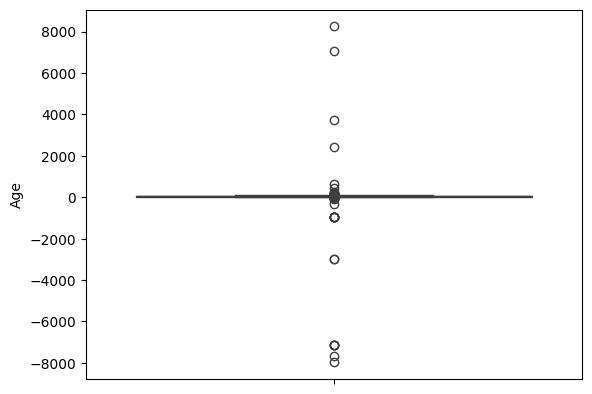

In [44]:
sb.boxplot(crime['Age']) ## vcelku absurdní graf - jsou tam značné outliery

### Odstranění outlierů z atributu Age

Pro odstranění atributů existuje velké množství postupů - uvažovali jsme ty nejsnadnější:
1) zscores - analýza si zakládá na přepodkladu normálního rozdělení (což zde bude jenom těžko). Je proto velmi těžké určit hodnotu, která by mohla sloužit jako spolehlivý threshold a neidentifikovali jsme si moc málo nebo příliš mnoho záznamů jako outliery
2) IQR - metoda založená na principu výpočtu rozdílu mezi prvním a třetím kvartilem, kdy za outliery se považují pozorování která nespadají do intervalu:
$$(prvníKvartil-1.5*IQR; třetíKvartil + 1,5*IQR)$$

Zvolili jsme druhou metodu.

<Axes: ylabel='Age'>

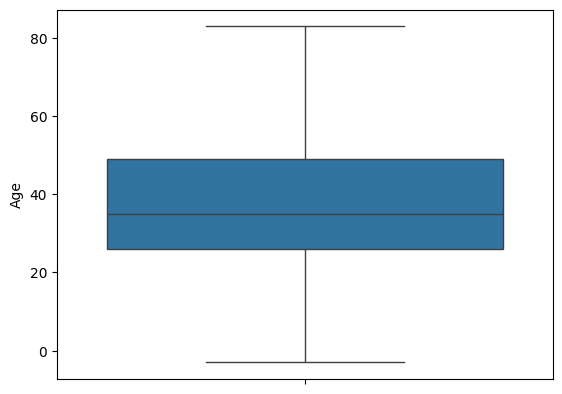

In [45]:
## vypočítáme kvartily a jejich rozdíl (IQR)
lower_quartile = crime['Age'].quantile(0.25)
upper_quartile = crime['Age'].quantile(0.75)
IQR = upper_quartile - lower_quartile

## určíme si hranice intervalu přijatelných hodnot
lower_bound = lower_quartile - 1.5 * IQR
upper_bound = upper_quartile + 1.5 * IQR

##vybereme pozorování, která nespadají do stanoveného intervalu
remove_lower = np.where(crime['Age'] <= lower_bound)[0]
remove_upper = np.where(crime['Age'] >= upper_bound)[0]

## tato data odstraníme
crime.drop(index = remove_lower, inplace= True)
crime.drop(index = remove_upper, inplace= True)

sb.boxplot(crime['Age']) ## nyní graf bez outlierů


In [46]:
## hodnoty doplníme opět z empirické distribuce
distribution = crime['Age'].value_counts(normalize = True) 

missing = crime['Age'].isnull()

fillings = np.random.choice(distribution.index, size = missing.sum(), p = distribution.values)

crime.loc[missing, 'Age'] = fillings

print(crime['Age'].isna().sum()) ## všechny hodnoty doplněny

0


### Odvození atributu Age_Category

Mohlo by být zajímavé sledovat vztahy mezi zločiny a věky obětí. Vzhledem k velkému množství hodnot by bylo vhodné atribut Age diskretizovat. Zvolili jsme poměrně věkoví kategorie, které k sobě dle nás mají určitými vlastnostmi blízko:
1) 0 - 18
2) 19 - 25
3) 26 - 35
4) 36 - 45
5) 46 - 55
6) 56 - 65
7) 66 - 75
8) 76 and older

In [47]:
bins=[0,18,25,35,45,55,65,75,100]

crime['Age_Category'] = pd.cut(crime['Age'], bins = bins, labels=['0-18','19-25','26-35','36-45','46-55','56-65','66-75','76 and older'])

crime.head(50)

,CrimeDateTime,Description,Weapon,Gender,Age,Race,Ethnicity,Old_District,Neighborhood,PremiseType,Total_Incidents,Latitude,Longitude,Month,Hour,Daytime,Age_Category
0,2013-09-05 06:30:00,LARCENY FROM AUTO,PERSONAL_WEAPONS,F,48.0,WHITE,NaN,NORTHERN,MEDFIELD,STREET,1,39.339060,-76.641489,September,6.0,Morning,46-55
1,2013-09-05 21:00:00,AGG. ASSAULT,HANDS,F,11.0,BLACK_OR_AFRICAN_AMERICAN,NaN,SOUTHEAST,BAYVIEW,ROW/TOWNHOUSE-OCC,1,39.289023,-76.538116,September,21.0,Night,0-18
2,2013-09-05 15:45:00,COMMON ASSAULT,PERSONAL_WEAPONS,M,22.0,BLACK_OR_AFRICAN_AMERICAN,NaN,EASTERN,PENN-FALLSWAY,STREET,1,39.300483,-76.606101,September,15.0,Afternoon,19-25
3,2013-09-05 01:10:00,ROBBERY,FIREARM,F,23.0,WHITE,NaN,NORTHERN,ROLAND PARK,STREET,1,39.352701,-76.638843,September,1.0,Early Morning,19-25
4,2013-09-05 20:00:00,BURGLARY,PERSONAL_WEAPONS,M,27.0,UNKNOWN,NaN,SOUTHERN,HOLLINS MARKET,SHED/GARAGE,1,39.286143,-76.636664,September,20.0,Evening,26-35
5,2013-09-05 22:38:00,COMMON ASSAULT,PERSONAL_WEAPONS,F,44.0,BLACK_OR_AFRICAN_AMERICAN,NaN,SOUTHERN,CHERRY HILL,ROW/TOWNHOUSE-OCC,1,39.243984,-76.621891,September,22.0,Night,36-45
6,2013-09-05 17:00:00,LARCENY FROM AUTO,PERSONAL_WEAPONS,F,40.0,WHITE,NaN,SOUTHERN,SOUTH BALTIMORE,STREET,1,39.273240,-76.616084,September,17.0,Evening,36-45
7,2013-09-05 01:27:00,BURGLARY,PERSONAL_WEAPONS,F,31.0,WHITE,NaN,SOUTHERN,FAIRFIELD AREA,ROW/TOWNHOUSE-OCC,1,39.241421,-76.607048,September,1.0,Early Morning,26-35
8,2013-09-05 16:45:00,BURGLARY,PERSONAL_WEAPONS,U,52.0,UNKNOWN,NaN,NORTHEAST,COLDSTREAM HOMESTEAD MONTEBELLO,APT/CONDO - OCCUPIED,1,39.326402,-76.588731,September,16.0,Afternoon,46-55
9,2013-09-05 08:00:00,AUTO THEFT,PERSONAL_WEAPONS,M,47.0,UNKNOWN,NaN,EASTERN,OLDTOWN,STREET,1,39.295750,-76.605535,September,8.0,Morning,46-55


## Atribut Race

Atribut race má nejenom nevyplněné hodnoty, ale zároveň má i hodnotu, která sice je vyplněná, avšak má hodnotu UKNOWN. Obě možnosti doplníme z empirického rozdělení.

In [48]:
## distribuci budeme počítat z podmnožiny datové sady, která neobsahuje UNKNOWN
distribution = crime[crime['Race'] != 'UNKNOWN']['Race'].value_counts(normalize=True)

## vybereme podmnožiny  s nevyplněnými hodnotami a hodnotami UNKNOWN
unknown = crime['Race'] == 'UNKNOWN'
missing = crime['Race'].isnull()

fillings = np.random.choice(distribution.index, size = unknown.sum(), p=distribution.values)

crime.loc[unknown,'Race'] = fillings

fillings = np.random.choice(distribution.index, size = missing.sum(), p=distribution.values)

crime.loc[missing,'Race'] = fillings

print(crime['Race'].value_counts(normalize = True)) ## distribuce zachována
print(crime['Race'].isna().sum()) ## nevyplněné hodnoty již nejsou

Race
BLACK_OR_AFRICAN_AMERICAN                    0.708727
WHITE                                        0.283997
ASIAN                                        0.004326
AMERICAN_INDIAN_OR_ALASKA_NATIVE             0.001966
NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER    0.000984
Name: proportion, dtype: float64
0


## Atribut Ethnicity

Atribut ethnicity je v podstatě nevyplněný a z těch hodnot, které vyplněné jsou je velká část hodnoty UNKNOWN. Tady se již neodvažujeme nahrazovat z empirické distribuce a proto atribut dále nebudeme používat.

In [49]:
print(crime['Ethnicity'].isna().sum()) ## počet nevyplněných hodnot
print(crime['Ethnicity'].value_counts()) ## počty hodnot pro jednotlivé kategorie

crime = crime.drop(['Ethnicity'], axis = 1)

527022
Ethnicity
NOT_HISPANIC_OR_LATINO    46584
UNKNOWN                   28495
HISPANIC_OR_LATINO         7608
MIDDLE_EASTERN              628
EAST_ASIAN                  266
SOUTH_ASIAN                 151
Name: count, dtype: int64


## Atribut Old_District

Atribut obsahuje nějaké nevyplněné hodnoty, ty doplníme z distribuce.

In [50]:
crime.Old_District.isna().sum()

46278

In [51]:
distribution = crime.Old_District.value_counts(normalize=True)

missing = crime.Old_District.isnull()

fillings = np.random.choice(distribution.index, size = missing.sum(), p=distribution.values) 

crime.loc[missing, 'Old_District'] = fillings

print(crime.Old_District.isna().sum()) 
print(crime.Old_District.value_counts(normalize=True))

0
Old_District
NORTHEAST       0.151812
SOUTHEAST       0.139596
CENTRAL         0.118355
SOUTHERN        0.114912
NORTHERN        0.108009
NORTHWEST       0.100451
SOUTHWEST       0.100152
EASTERN         0.086891
WESTERN         0.079808
NORTHWESTERN    0.000005
SOUTHEASTERN    0.000003
NORTHEASTERN    0.000002
BAL             0.000002
SOUTHWESTERN    0.000002
Name: proportion, dtype: float64


## Atribut Neighborhood

Tento atribut má menší množství nevyplněných hodnot, ale vzhledem k poměrně vyrovnané distribuci hodnot budeme doplňovat právě z ní a ne modem.

In [52]:
print(crime.Neighborhood.isna().sum())
print(crime.Neighborhood.value_counts(normalize=True))

8745
Neighborhood
DOWNTOWN                   0.035343
FRANKFORD                  0.024069
BELAIR-EDISON              0.021425
BROOKLYN                   0.018854
CANTON                     0.014864
                             ...   
VILLAGES OF HOMELAND       0.000110
GREENMOUNT CEMETERY        0.000071
MT PLEASANT PARK           0.000061
BLYTHEWOOD                 0.000023
DUNDALK MARINE TERMINAL    0.000003
Name: proportion, Length: 278, dtype: float64


In [53]:
distribution = crime.Neighborhood.value_counts(normalize = True)

missing = crime.Neighborhood.isnull()

fillings  = np.random.choice(distribution.index, size = missing.sum(), p = distribution.values)

crime.loc[missing, 'Neighborhood'] = fillings


print(crime.Neighborhood.isna().sum()) ## počet nevyplněných hodnot


0


## Atribut Description

Sjednotíme některé typy zločinů do jedné kategorie, neboť mají podobný charakter.

In [54]:
crime['Description'] = crime['Description'].replace(['ROBBERY', 'ROBBERY - COMMERCIAL'], 'ROBBERY')
crime['Description'] = crime['Description'].replace(['AUTO THEFT', 'ROBBERY - CARJACKING'], 'AUTO THEFT')

## Atribut PremiseType

Sjednotíme smysluplně některé typy místa zločinu do agregovaných kategorií, neboť tato místa vykazují podobný charakter a do některých spadá jen minimum záznamů. Chybějící hodnoty doplníme dle daného zločinu.

In [55]:
crime['PremiseType'] = crime['PremiseType'].str.strip() ## některé hodnoty mají bílé znaky na konci
crime['PremiseType'] = crime['PremiseType'].replace(['APARTMENT HALLWAY', 'APT. LOCKER/LAUNDRY', 'APT/CONDO - OCCUPIED', 'APT/CONDO - VACANT','ROW/TOWNHOUSE-OCC','ROW/TOWNHOUSE-VAC','SINGLE HOUSE'], 'APARTMENT')
crime['PremiseType'] = crime['PremiseType'].replace(['AUTO PARTS STORE','BAKERY','CHAIN FOOD STORE','CLOTHING/SHOE STORE','CONVENIENCE STORE','DEPARTMENT STORE','DRUG STORE / MED  BL','GROCERY/CONFECTION','JEWELRY STORE','LIQUOR STORE','PAWN SHOP','RENTAL/VIDEO STORE','SHOPPING MALLS/CNTR','SPECIALTY STORE','WHOLESALE/DISC. STOR'], 'STORE')
crime['PremiseType'] = crime['PremiseType'].replace(['BOAT YARD', 'BOAT/SHIP','RIDGE-PIERS-DOCKS'], 'BOAT')
crime['PremiseType'] = crime['PremiseType'].replace(['BUS.  STORAGE SHED', 'BUS. PARK LOT-INSIDE','BUS. PARK LOT-OUTSID','BUS/RAILROAD STATION','CAB','CAR LOT-NEW/USED','BOX CARS/COMM\'L TRLR','TRACTOR TRAILER','TRUCK DRIVERS-OIL-','TRUCKING & TRANSFER','VEHICLE'], 'BUS/CAB/CAR')
crime['PremiseType'] = crime['PremiseType'].replace(['INNER HARBOR-N-PRATT', 'INNER HARBOR-S-KEY','INNER HARBOR-W-LIGHT'], 'HARBOR')
crime['PremiseType'] = crime['PremiseType'].replace(['PARKING LOT', 'PARKING LOT-INSIDE','PARKING LOT-OUTSIDE'], 'PARKING LOT')
crime['PremiseType'] = crime['PremiseType'].replace(['PUBLIC SCHOOL', 'SCHOOL','SCHOOL PLAYGROUND','PRIVATE SCHOOL','DAY CARE FACILITY'], 'SCHOOL')
crime['PremiseType'] = crime['PremiseType'].replace(['BANK/FINANCIAL INST', 'FINANCE/LOAN COMPANY','ATM MACHINES'], 'BANK/FINANCIAL INST')
crime['PremiseType'] = crime['PremiseType'].replace(['STREET', 'ALLEY'], 'STREET')
crime['PremiseType'] = crime['PremiseType'].replace(['ARENA', 'CONVENTION CENTER','STADIUM'], 'EVENT')
crime['PremiseType'] = crime['PremiseType'].replace(['BAR', 'CLUB HOUSE/FRATERNIT','FAST FOOD','PIZZA/OTHER DELIVERY','RESTAURANT','TAVERN/NIGHT CLUB'], 'BAR/RESTAURANT')
crime['PremiseType'] = crime['PremiseType'].replace(['BLDG UNDER CONST.', 'CONSTRUCTION SITE','HOUSE UNDER CONSTRUC'], 'CONSTRUCTION')
crime['PremiseType'] = crime['PremiseType'].replace(['DOCTORS OFFICE', 'HOSP/NURS. HOME','HOSPITAL'], 'MEDICAL CENTER')
crime['PremiseType'] = crime['PremiseType'].replace(['GARAGE', 'GARAGE ON PRIV. PROP','SHED','SHED/GARAGE'], 'GARAGE')
crime['PremiseType'] = crime['PremiseType'].replace(['CHURCH', 'CEMETERY','RELIGIOUS  INSTITUTI'], 'RELIGION SPOT')
crime['PremiseType'] = crime['PremiseType'].replace(['YARD', 'YARD/BUSINESS'], 'YARD')


crime.PremiseType.value_counts(normalize=True)

PremiseType
STREET                 0.397560
APARTMENT              0.230876
OTHER/RESIDENTIAL      0.078203
STORE                  0.057963
PARKING LOT            0.037205
                         ...   
STRUCTURE-OCCUPIED     0.000022
MAILBOX-STREET/RES.    0.000022
MOBILE HOME            0.000013
PHOTO STUDIO/CAMERA    0.000011
MANUFACTURING PLANT    0.000007
Name: proportion, Length: 68, dtype: float64

In [56]:
mode_per_description = crime.groupby('Description')['PremiseType'].apply(lambda x: x.mode().values[0])

crime['PremiseType'] = crime.apply(lambda row: mode_per_description[row['Description']] if pd.isnull(row['PremiseType']) else row['PremiseType'], axis=1)


## Atribut Total_Incidents

U tohoto atributu jsme si všimli, že má pouze jednu hodnotu a proto ho odstraníme.

In [57]:
print(crime.Total_Incidents.isna().sum())
print(crime.Total_Incidents.value_counts(normalize=True))

crime = crime.drop(['Total_Incidents'], axis = 1)

0
Total_Incidents
1    1.0
Name: proportion, dtype: float64


## Atributy Latitude a Longitude

U těchto atributů doplňování z distribuce nedává příliš smysl, vzhledem k jejich povaze (poloha). Proto z datasetu odstraníme záznamy s chybějícími hodnotami (není jich mnoho).

In [58]:
## odstraňujeme takové záznamy, které mají zeměpisnou šířku nebo délku nulovou nebo nevyplněnou
crime = crime[(crime['Longitude'] != 0.0) & (crime['Latitude'] != 0.0) & (crime['Longitude'].notnull()) & (crime['Latitude'].notnull())] 

## zresetujeme index po odstranění řádků
crime = crime.reset_index(drop = True)


## Odvozený atribut Police_in_neigh

Bylo by zajímavé vidět, zda v sousedství, ve kterém se stal zločin, má policejní stanici. Těch je pouze 8, takže u většiny to tak nebude. Mohlo by být ovšem zajímavé vidět, zda přítomnost policejní stanice v daném sousedství má vliv na počet nebo typ zločinů. 

In [59]:
## inicializace atributu

crime['Police_in_neigh'] = 0

In [60]:
## extrakce sousedství, ve kterých jsou policejní stanice
police_neighborhoods = set()

for neighborhood in police_stations['nghbrhd']:
    police_neighborhoods.add(neighborhood.upper()) ## převod do upper case - sjednocení s druhým datasetem

police_neighborhoods

{'BEREA',
 'DOWNTOWN',
 'GWYNNS FALLS',
 'HOPKINS BAYVIEW',
 'MIDDLE BRANCH/REEDBIRD PARKS',
 'MORGAN STATE UNIVERSITY',
 'SANDTOWN-WINCHESTER',
 'WOODBERRY',
 'WOODMERE'}

In [61]:
## jestliže je v daném řádku sousedství, ve kterém je policejní stanice, tak ve sloupci Police_in_neigh bude hodnota 1
for i in range(len(crime)):
    if crime.loc[i,'Neighborhood'] in police_neighborhoods:
        crime.loc[i,'Police_in_neigh'] = 1

## Atribut Distance_to_police

Zajímavé by bylo spočítat vzdálenost místa činu od policejní stanice, která má na starost danou čtvrť. Vycházet budeme ze zeměpisných šířek a délek v obou datasetech.

Bude zapotřebí sjednotit pojmenování čtvrti a spočítat vzdálenosti (v metrech). Pro tyto výpočty použijeme knihovnu geopy.

In [62]:
## uložíme si obě hodnoty do jednoho atributu
police_stations['District_coordinates'] = list(zip(police_stations.Latitude,police_stations.Longitude))

police_stations.head()

,subtype,nghbrhd,plcdst,Latitude,Longitude,District_coordinates
0,Headquarters,Downtown,CENTRAL,39.3230,-76.6223,"(39.323, -76.6223)"
1,Police Station,Downtown,CENTRAL,39.2900,-76.6085,"(39.29, -76.6085)"
2,Police Station,Woodberry,NORTHERN,39.3431,-76.6524,"(39.3431, -76.6524)"
3,Police Station,Morgan State University,NORTHEASTERN,39.3408,-76.5828,"(39.3408, -76.5828)"
4,Police Station,Woodmere,NORTHWESTERN,39.3446,-76.6854,"(39.3446, -76.6854)"


In [63]:
## nebudeme uvažovat velitelství - budeme přepodkládat, že odtud se zásahy nevedou
police_stations = police_stations[police_stations['subtype'] != 'Headquarters']

## sjednotíme názvosloví obou datasetů
police_stations['plcdst'] = police_stations['plcdst'].replace({'NORTHEASTERN': 'NORTHEAST', 'SOUTHEASTERN': 'SOUTHEAST', 'NORTHWESTERN': 'NORTHWEST', 'SOUTHWESTERN': 'SOUTHWEST'})

## uložíme si do dictionary jednotlivé stanice a jejich lokaci
district_coordinates = police_stations.set_index('plcdst')['District_coordinates'].to_dict()
district_coordinates

{'CENTRAL': (39.29, -76.6085),
 'NORTHERN': (39.3431, -76.6524),
 'NORTHEAST': (39.3408, -76.5828),
 'NORTHWEST': (39.3446, -76.6854),
 'EASTERN': (39.31, -76.5734),
 'SOUTHERN': (39.2529, -76.6172),
 'SOUTHEAST': (39.2877, -76.5475),
 'SOUTHWEST': (39.2784, -76.6638),
 'WESTERN': (39.3007, -76.6448)}

In [68]:
crime['Old_District'] = crime['Old_District'].replace({'NORTHEASTERN': 'NORTHEAST', 'SOUTHEASTERN': 'SOUTHEAST', 'NORTHWESTERN': 'NORTHWEST', 'SOUTHWESTERN': 'SOUTHWEST'})


In [64]:
## funkci budeme aplikovat na každý řádek, který tak bude vstupovat jako parametr
def distance(row):
    crime_location = (row['Latitude'], row['Longitude']) ## pro řádek vytáhneme jeho zeměpisné údaje
    police_station_location = district_coordinates[row['Old_District']] ## vezmeme zeměpisné údaje pro odpovídající policejní stanici
    return geodesic(crime_location, police_station_location).meters ## vypočítáme vzdálenost v metrech od místa činu k policejní stanici dané čtvrti

In [69]:
## výsledek funkce se aplikuje na každý řádek do atributu distance_to_police
crime['distance_to_police'] = crime.apply(distance, axis = 1)

crime.head(50)

,CrimeDateTime,Description,Weapon,Gender,Age,Race,Old_District,Neighborhood,PremiseType,Latitude,Longitude,Month,Hour,Daytime,Age_Category,Police_in_neigh,Old_District\t,distance_to_police
0,2013-09-05 06:30:00,LARCENY FROM AUTO,PERSONAL_WEAPONS,F,48.0,WHITE,NORTHERN,MEDFIELD,STREET,39.339060,-76.641489,September,6.0,Morning,46-55,0,NORTHERN,1042.091866
1,2013-09-05 21:00:00,AGG. ASSAULT,HANDS,F,11.0,BLACK_OR_AFRICAN_AMERICAN,SOUTHEAST,BAYVIEW,APARTMENT,39.289023,-76.538116,September,21.0,Night,0-18,0,SOUTHEAST,822.808371
2,2013-09-05 15:45:00,COMMON ASSAULT,PERSONAL_WEAPONS,M,22.0,BLACK_OR_AFRICAN_AMERICAN,EASTERN,PENN-FALLSWAY,STREET,39.300483,-76.606101,September,15.0,Afternoon,19-25,0,EASTERN,3011.994340
3,2013-09-05 01:10:00,ROBBERY,FIREARM,F,23.0,WHITE,NORTHERN,ROLAND PARK,STREET,39.352701,-76.638843,September,1.0,Early Morning,19-25,0,NORTHERN,1581.769901
4,2013-09-05 20:00:00,BURGLARY,PERSONAL_WEAPONS,M,27.0,BLACK_OR_AFRICAN_AMERICAN,SOUTHERN,HOLLINS MARKET,GARAGE,39.286143,-76.636664,September,20.0,Evening,26-35,0,SOUTHERN,4054.909354
5,2013-09-05 22:38:00,COMMON ASSAULT,PERSONAL_WEAPONS,F,44.0,BLACK_OR_AFRICAN_AMERICAN,SOUTHERN,CHERRY HILL,APARTMENT,39.243984,-76.621891,September,22.0,Night,36-45,0,SOUTHERN,1069.481928
6,2013-09-05 17:00:00,LARCENY FROM AUTO,PERSONAL_WEAPONS,F,40.0,WHITE,SOUTHERN,SOUTH BALTIMORE,STREET,39.273240,-76.616084,September,17.0,Evening,36-45,0,SOUTHERN,2260.210219
7,2013-09-05 01:27:00,BURGLARY,PERSONAL_WEAPONS,F,31.0,WHITE,SOUTHERN,FAIRFIELD AREA,APARTMENT,39.241421,-76.607048,September,1.0,Early Morning,26-35,0,SOUTHERN,1546.644931
8,2013-09-05 16:45:00,BURGLARY,PERSONAL_WEAPONS,U,52.0,BLACK_OR_AFRICAN_AMERICAN,NORTHEAST,COLDSTREAM HOMESTEAD MONTEBELLO,APARTMENT,39.326402,-76.588731,September,16.0,Afternoon,46-55,0,NORTHEAST,1678.293092
9,2013-09-05 08:00:00,AUTO THEFT,PERSONAL_WEAPONS,M,47.0,WHITE,EASTERN,OLDTOWN,STREET,39.295750,-76.605535,September,8.0,Morning,46-55,0,EASTERN,3191.538444


In [ ]:
## uložení do csv
crime.to_csv('crime_stations_transformed2.csv', index=False)


In [1]:
crime.Daytime.value_counts(normalize=True)

NameError: name 'crime' is not defined